In [1]:
# 「Chest X-Ray Images(Pnuemonia)」で肺炎か診断
#  前処理で保存した特徴量、ターゲットから
#  データを拡張して学習する

In [2]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

import os
import glob

%matplotlib inline


In [3]:
# path の設定
test_path = "./dataset/chest_xray/test/"
train_path ='./dataset/chest_xray/train/'

In [4]:
# 訓練データ読み出し
X_train = np.load(train_path + 'X_train.npy')
y_train = np.load(train_path + 'y_train.npy')

In [5]:
X_train.shape, y_train.shape

((5216, 64, 64, 3), (5216,))

In [6]:
# テストデータ読み出し
X_test = np.load(test_path + 'X_test.npy')
y_test = np.load(test_path + 'y_test.npy')

In [7]:
X_test.shape, y_test.shape

((624, 64, 64, 3), (624,))

In [8]:
# ImageDataGenerator
data_gen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True
)

In [9]:
# 訓練データの加工
aug_img = []

for i, batch in enumerate(data_gen.flow(X_train, shuffle=False, batch_size=2, seed=42)):
    aug_img.append(batch)
    
    if i > 5:
        # とりあえず6つだけ
        break

In [10]:
len(aug_img)

7

Text(0.5, 1.0, 'Augmented_2')

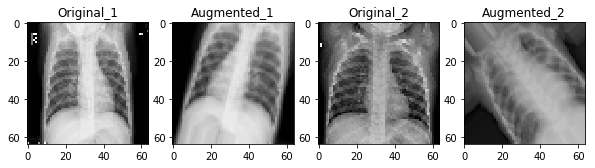

In [11]:
# 加工データの確認
fix, ax = plt.subplots(1, 4, figsize=(10, 10))

# 元データ
plt.subplot(141)
plt.imshow(X_train[0])
plt.title('Original_1')

# 加工データ
plt.subplot(142)
plt.imshow(aug_img[0][0])
plt.title('Augmented_1')

# 元データ
plt.subplot(143)
plt.imshow(X_train[1])
plt.title('Original_2')

# 加工データ
plt.subplot(144)
plt.imshow(aug_img[1][0])
plt.title('Augmented_2')


In [12]:
# 前回と同じ構造で
aug_model = Sequential()
aug_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64, 64, 3)))
aug_model.add(MaxPooling2D(pool_size=(2, 2)))
aug_model.add(Dropout(0.25))
aug_model.add(Flatten())
aug_model.add(Dense(128, activation='relu'))
aug_model.add(Dropout(0.33))
aug_model.add(Dense(1, activation='sigmoid'))

aug_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
________________________________________________

In [13]:
# コンパイル
aug_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.00001),
                  metrics=['accuracy'])

In [14]:
# EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', patience=3)

In [15]:
aug_model.fit_generator(
    data_gen.flow(X_train, y_train, batch_size=32, seed=42),
    steps_per_epoch=163,
    epochs=20,
    verbose=1,
    shuffle=False,
    callbacks=[callbacks],
    validation_data=(X_test, y_test)
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
163/163 [==============================] - 35s 216ms/step - loss: 0.5719 - accuracy: 0.7418 - val_loss: 0.6202 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 31s 191ms/step - loss: 0.5386 - accuracy: 0.7450 - val_loss: 0.5620 - val_accuracy: 0.6522
Epoch 3/20
163/163 [==============================] - 32s 197ms/step - loss: 0.5039 - accuracy: 0.7573 - val_loss: 0.5356 - val_accuracy: 0.6554
Epoch 4/20
163/163 [==============================] - 32s 197ms/step - loss: 0.4677 - accuracy: 0.7772 - val_loss: 0.4757 - val_accuracy: 0.8381
Epoch 5/20
163/163 [==============================] - 31s 193ms/step - loss: 0.4351 - accuracy: 0.8064 - val_loss: 0.4453 - val_accuracy: 0.7981
Epoch 6/20
163/163 [==============================] - 32s 198ms/step - loss: 0.4117 - accuracy: 0.8127 - val_loss: 0.4188 - val_accuracy: 0.8317
Epoch 7/20
163/163 [==============================] - 33s 202ms/step - loss: 0.388

In [16]:
aug_y_pred = aug_model.predict_classes(X_test)

In [17]:
confusion_matrix(y_test, aug_y_pred)

array([[192,  42],
       [ 51, 339]], dtype=int64)

In [18]:
accuracy_score(y_test, aug_y_pred)

0.8509615384615384

In [19]:
precision_score(y_test, aug_y_pred)

0.889763779527559

In [20]:
recall_score(y_test, aug_y_pred)

0.8692307692307693

In [21]:
f1_score(y_test, aug_y_pred)

0.8793774319066148